In [ ]:
# git clone https://github.com/voorhs/AutoIntent.git if an error occurs somewhere, it is better to remove '#', maybe it helps
# !cd AutoIntent
!pip install autointent

fatal: destination path 'AutoIntent' already exists and is not an empty directory.


In [ ]:
import random
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import numpy as np

from typing import List
from autointent.generation.chat_templates import Message, Role
from autointent import Dataset
from autointent.custom_types import Split
from autointent.generation import Generator
from autointent.schemas import Sample
from autointent.generation.utterances import UtteranceGenerator
from autointent.generation.chat_templates import EnglishSynthesizerTemplate
from autointent.modules import LinearScorer
from autointent.metrics import scoring_accuracy,  \
                               scoring_precision, \
                               scoring_recall,    \
                               scoring_f1
from datasets import concatenate_datasets, Dataset as HFDataset

In [ ]:
# new class

class AllIntentGenerator(UtteranceGenerator):
    def __init__(self, reasoning_generator: Generator, selection_generator: Generator):
        self.reasoning_generator = reasoning_generator  # To generate examples with explanations
        self.selection_generator = selection_generator  # To select the BEST answers

    def _build_class_level_prompt(
        self,
        examples: list[str],
        intent_name: str,
        other_intent: str,
        n_generate: int,
    ) -> Message:
        example_block = "\n".join(f"{i + 1}. {ex}" for i, ex in enumerate(examples))

        content = (
            f"Generate {n_generate} diverse, natural-sounding utterances for the intent "
            f"'{intent_name}'. Each example must clearly belong to '{intent_name}' and NOT to "
            f"'{other_intent}'. Follow these steps:\n\n"

            f"1. Examples of '{intent_name}':\n"
            f"{example_block}\n\n"

            f"2. Generate {n_generate} new examples numbered 1-{n_generate} using the EXACT format "
            f"below for every example:\n"
            f"   - Line 1: the utterance ONLY (no explanation or extra text).\n"
            f"   - Line 2: `Reasoning:` your explanation of why it fits '{intent_name}' and not "
            f"'{other_intent}'.\n\n"

            f"3. Analysis:\n"
            f"   - Identify the best example(s) (clearest fit for '{intent_name}' and farthest from "
            f"'{other_intent}').\n"
            f"   - Suggest which to choose for optimal distinctiveness.\n\n"

            f"Rules:\n"
            f"- Do NOT repeat provided examples.\n"
            f"- Utterance lines MUST contain ONLY the utterance text.\n"
            f"- Explanations MUST start on the next line with `Reasoning:`.\n"
            f"- Prioritize natural, human-like phrasing.\n"
            f"- Ensure clear contrast with '{other_intent}'."
        )
        return Message(role=Role.USER, content=content)
        return Message(role=Role.USER, content=content)

    def _build_critic_prompt(
        self,
        candidates: list[str],
        intent_name: str,
        other_intent_names: list[str], # doesn't use
        n_select: int,
    ) -> Message:
        options = "\n".join(f"{i + 1}. {s}" for i, s in enumerate(candidates))
        plural = "utterances" if n_select > 1 else "utterance"
        content = (
            f"Select the {n_select} BEST {plural} for intent '{intent_name}'"
            f"Return ONLY the numbers of the selected {plural} separated by commas (e.g. '3,5,7').\n\n"
            f"Options:\n{options}"
        )
        return Message(role=Role.USER, content=content)

    def generate(
        self,
        dataset: Dataset,
        split_name: str = Split.TRAIN,
        n_final_per_class: int = 1,
        update_split: bool = True,
    ) -> list[Sample]:

        n_generate = n_final_per_class * 5 # 5 options for 1 necessary

        original_split = dataset[split_name]
        id_to_name = {intent.id: intent.name for intent in dataset.intents}
        utterances_by_intent = defaultdict(list)

        for sample in original_split:
            utterances_by_intent[sample["label"]].append(sample["utterance"])

        new_samples = []

        for intent_id, examples in utterances_by_intent.items():
            intent_name = id_to_name[intent_id]
            other_intent_names = [id_to_name[i] for i in id_to_name if i != intent_id]
            other_intent = random.choice(other_intent_names)
            few_shots = random.sample(examples, min(5, len(examples)))

            print(f"\n Generating for intent: {intent_name} (id={intent_id})")

            reasoning_prompt = self._build_class_level_prompt(
                few_shots, intent_name, other_intent, n_generate
            )
            raw_response = self.reasoning_generator.get_chat_completion([reasoning_prompt])
            candidates = self._extract_utterances(raw_response)

            # Сhoosing the best n_final_per_class
            if len(candidates) < n_final_per_class:
                selected_ids = list(range(1, len(candidates) + 1))
            else:
                critic_prompt = self._build_critic_prompt(
                    candidates,
                    intent_name,
                    other_intent_names,
                    n_select=n_final_per_class,
                )
                critic_response = self.selection_generator.get_chat_completion([critic_prompt])
                selected_ids = self._parse_indices_from_critic_response(
                    critic_response, max_id=len(candidates), n_select=n_final_per_class
                )

                if len(selected_ids) < n_final_per_class:
                    remaining = [
                        i for i in range(1, len(candidates) + 1) if i not in selected_ids
                    ][: n_final_per_class - len(selected_ids)]
                    selected_ids.extend(remaining)

            for idx in selected_ids:
                new_samples.append(
                    {
                        Dataset.label_feature: intent_id,
                        Dataset.utterance_feature: candidates[idx - 1],
                    }
                )

        if update_split and new_samples:
            generated_split = HFDataset.from_list(new_samples)
            dataset[split_name] = concatenate_datasets([original_split, generated_split])

        return [Sample(**sample) for sample in new_samples]

    def _extract_utterances(self, response_text: str) -> list[str]:
        utterances = []
        for line in response_text.strip().split("\n"):
            match = re.match(r"^\s*\d+\.\s+(.*)", line)
            if match:
                utterances.append(match.group(1).strip())
        return utterances

    def _parse_indices_from_critic_response(
        self, response: str, max_id: int, n_select: int
    ) -> list[int]:
        matches = re.findall(r"\d+", response)
        result: list[int] = []
        for m in matches:
            idx = int(m)
            if 1 <= idx <= max_id and idx not in result:
                result.append(idx)
            if len(result) == n_select:
                break
        return result

Dataset({
    features: ['utterance', 'label'],
    num_rows: 35
})

In [ ]:
# for tests

snips =  Dataset.from_hub("DeepPavlov/snips")

def create_shot_dataframe(full_dataset:Dataset, n=10, text_column='utterance', label_column='label'):
    utterances = []
    labels = []
    for label in np.unique(full_dataset['train']['label']):
        label_col = full_dataset['train'].filter(lambda x: x['label'] == label)
        utterances.extend(label_col['utterance'][:n])
        labels.extend(label_col['label'][:n])
    data_dict = {
    'train': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(utterances, labels)],

    'test': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(full_dataset['test']['utterance'], full_dataset['test']['label'])]
    }
    shot_dataset = Dataset.from_dict(data_dict)
    shot_dataset.intents = full_dataset.intents
    return shot_dataset


train_df = create_shot_dataframe(snips, n=10)


def metrics(labels, predictions):
    accuracy = scoring_accuracy(labels=labels, scores=predictions)
    f1 = scoring_f1(labels=labels, scores=predictions)
    precision = scoring_precision(labels=labels, scores=predictions)
    recall = scoring_recall(labels=labels, scores=predictions)
    return {'ac':accuracy, "f1":f1, "pre":precision, "recall":recall}


def pipe(data_x, data_y, test_x, test_y):
    scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo", cv=2
    )
    scorer.fit(data_x, data_y)
    probabilities = scorer.predict(test_x)
    metr = metrics(labels=test_y, predictions=probabilities)
    return metr


def show_diff(no_augment_data, baseline_data, model_data, test):
    no_augment = pipe(
        data_x=no_augment_data['train']['utterance'],
        data_y=no_augment_data['train']['label'],
        test_x=test['test']['utterance'],
        test_y=test['test']['label']
    )
    base_result = pipe(
        data_x=baseline_data['train']['utterance'],
        data_y=baseline_data['train']['label'],
        test_x=test['test']['utterance'],
        test_y=test['test']['label']
    )

    adv_result = pipe(
        data_x=model_data['train']['utterance'],
        data_y=model_data['train']['label'],
        test_x=test['test']['utterance'],
        test_y=test['test']['label']
    )

    print("Few-shot:", base_result)
    print("augmentation:", adv_result)

    return (no_augment, base_result, adv_result)

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Dataset({
    features: ['utterance', 'label'],
    num_rows: 70
})
[Intent(id=0, name='AddToPlaylist', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=1, name='BookRestaurant', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=2, name='GetWeather', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=3, name='PlayMusic', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=4, name='RateBook', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=5, name='SearchCreativeWork', tags=[], regex_full_match=[], regex_partial_match=[], description=None), Intent(id=6, name='SearchScreeningEvent', tags=[], regex_full_match=[], regex_partial_match=[], description=None)]


In [ ]:
# tests

gen_350 = Generator(
    base_url='http://193.187.173.33:8002/api/providers/openai/v1',
    model_name='gpt-3.5-turbo',
    max_tokens = 1_000 # sometimes there are not enough tokens to generate for AllIntentGenerator
)
test = snips

results = {'no_augment': [],
           'baseline':   [],
           'new_model':  []}

for i in range(8):
    n_final_per_class=5

    # create_shot_dataframe return each timethe same Dataset

    no_augment_data = create_shot_dataframe(snips, n=5)

    model_data = create_shot_dataframe(snips, n=5)
    new_augmenter = AllIntentGenerator(gen_350,gen_350)
    new_augmenter.generate(model_data, n_final_per_class=n_final_per_class, update_split=True)

    baseline_data = create_shot_dataframe(snips, n=5)
    baseline_augmenter = UtteranceGenerator(gen_350, EnglishSynthesizerTemplate(baseline_data))
    baseline_augmenter.augment(baseline_data, n_generations=n_final_per_class, update_split=True)

    res = show_diff(no_augment_data=no_augment_data, baseline_data=baseline_data, model_data=model_data, test=snips)

    for result, type_ in zip(res, results.keys()):
        results[type_].append(result)

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8542857142857143, 'f1': 0.8515090407948008, 'pre': 0.8521622762268107, 'recall': 0.8542857142857143}
augmentation: {'ac': 0.855, 'f1': 0.8477222054704526, 'pre': 0.8538190948892755, 'recall': 0.8550000000000001}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8657142857142858, 'f1': 0.8620948206412181, 'pre': 0.8626150480253353, 'recall': 0.8657142857142857}
augmentation: {'ac': 0.8871428571428571, 'f1': 0.8864984845067624, 'pre': 0.8878032286316176, 'recall': 0.887142857142857}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8742857142857143, 'f1': 0.8712214299306436, 'pre': 0.8736995225172078, 'recall': 0.8742857142857143}
augmentation: {'ac': 0.8642857142857143, 'f1': 0.8590680443720462, 'pre': 0.8606549279607686, 'recall': 0.8642857142857142}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8771428571428571, 'f1': 0.8717558246748246, 'pre': 0.8748198132849129, 'recall': 0.8771428571428571}
augmentation: {'ac': 0.8442857142857143, 'f1': 0.8377183837293029, 'pre': 0.8459611341601088, 'recall': 0.8442857142857142}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8785714285714286, 'f1': 0.8749547692084508, 'pre': 0.8758357914833902, 'recall': 0.8785714285714284}
augmentation: {'ac': 0.85, 'f1': 0.8416350646393245, 'pre': 0.8474032699526991, 'recall': 0.85}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.8714285714285714, 'f1': 0.8684895924427367, 'pre': 0.8701746765179675, 'recall': 0.8714285714285716}
augmentation: {'ac': 0.8642857142857143, 'f1': 0.8568637492140926, 'pre': 0.8673371732243581, 'recall': 0.8642857142857142}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.86, 'f1': 0.8571760352816807, 'pre': 0.8577747478888622, 'recall': 0.86}
augmentation: {'ac': 0.8678571428571429, 'f1': 0.8658567206338551, 'pre': 0.8660067212355729, 'recall': 0.8678571428571429}


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]


🔹 Generating for intent: AddToPlaylist (id=0)

🔹 Generating for intent: BookRestaurant (id=1)

🔹 Generating for intent: GetWeather (id=2)

🔹 Generating for intent: PlayMusic (id=3)

🔹 Generating for intent: RateBook (id=4)

🔹 Generating for intent: SearchCreativeWork (id=5)

🔹 Generating for intent: SearchScreeningEvent (id=6)


Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35 [00:00<?, ? examples/s]

Few-shot: {'ac': 0.7592857142857142, 'f1': 0.7577668048183905, 'pre': 0.7912680338461585, 'recall': 0.7592857142857142}
augmentation: {'ac': 0.8671428571428571, 'f1': 0.8620876009631379, 'pre': 0.8666900947650419, 'recall': 0.8671428571428571}


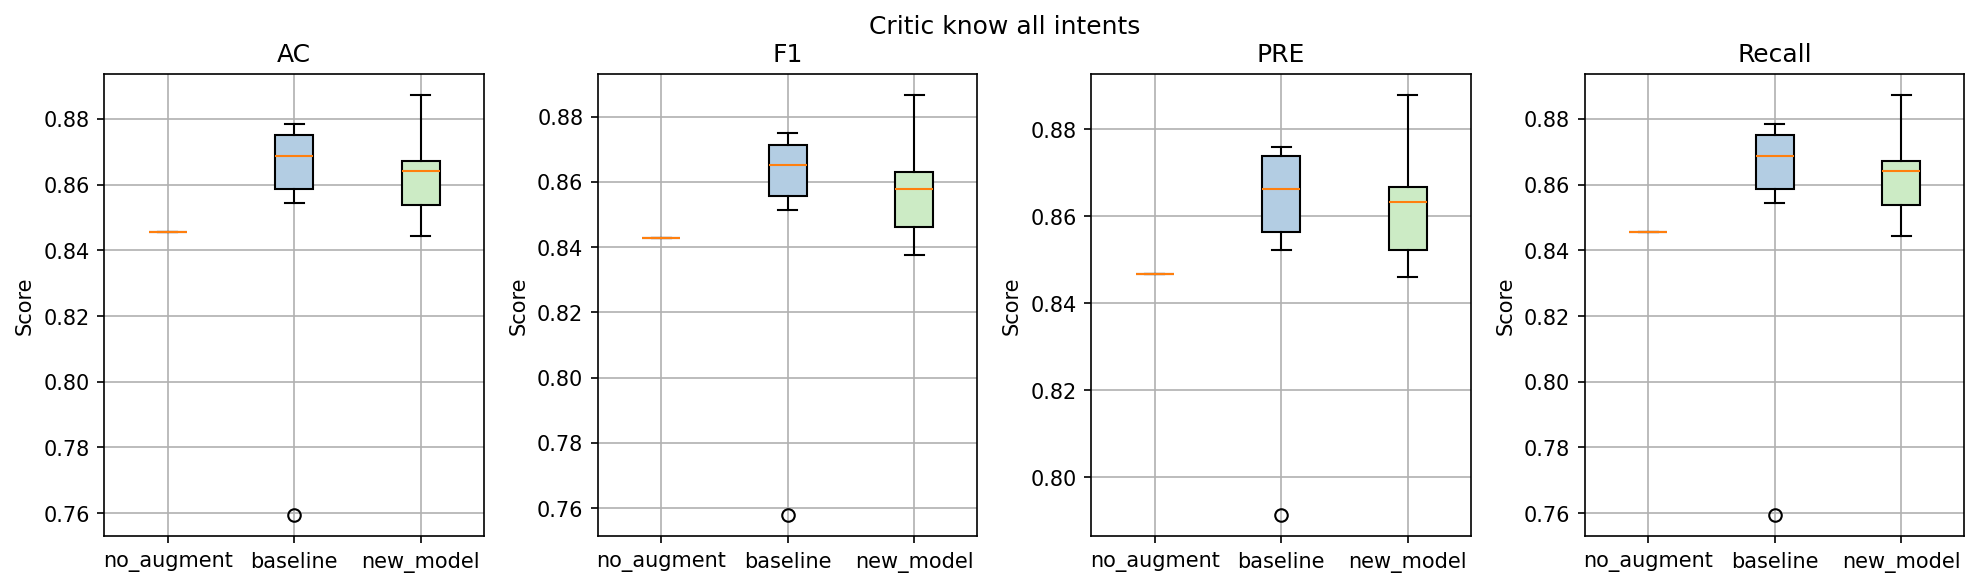

In [ ]:
# boxplot

models = list(results.keys())                      # ['baseline', 'new_model', 'no_augment']
metrics = list(results[models[0]][0].keys())        # ['ac', 'f1', 'pre', 'recall']


metric_names = [m.upper() if len(m) <= 3 else m.capitalize() for m in metrics]
colors = plt.cm.Pastel1.colors[:len(models)]

plt.figure(figsize=(4 * len(metrics), 4), dpi=150)
plt.subplots_adjust(wspace=0.3)

for i, (metric, name) in enumerate(zip(metrics, metric_names), 1):
    plt.subplot(1, len(metrics), i)

    data = [
        [run[metric] for run in results[model]]
        for model in models
    ]

    box = plt.boxplot(data, patch_artist=True, tick_labels=models)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(name)
    plt.ylabel('Score')
    plt.grid(True)

plt.suptitle('Critic know all intents')
plt.show()